<a href="https://colab.research.google.com/github/Kim-matthew-0422/GAN-style/blob/main/GAN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Streaming output truncated to the last 5000 lines.
  inflating: resized/resized/Henri_Rousseau_62.jpg  
  inflating: resized/resized/Henri_Rousseau_63.jpg  
  inflating: resized/resized/Henri_Rousseau_64.jpg  
  inflating: resized/resized/Henri_Rousseau_65.jpg  
  inflating: resized/resized/Henri_Rousseau_66.jpg  
  inflating: resized/resized/Henri_Rousseau_67.jpg  
  inflating: resized/resized/Henri_Rousseau_68.jpg  
  inflating: resized/resized/Henri_Rousseau_69.jpg  
  inflating: resized/resized/Henri_Rousseau_7.jpg  
  inflating: resized/resized/Henri_Rousseau_70.jpg  
  inflating: resized/resized/Henri_Rousseau_8.jpg  
  inflating: resized/resized/Henri_Rousseau_9.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_1.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_10.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_11.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_12.jpg  
  inflating: resized/resized/Henri_de_Toulouse-Lautrec_13.jpg

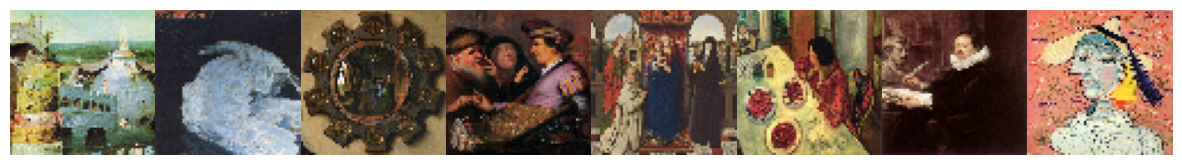

In [ ]:

from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d ikarus777/best-artworks-of-all-time
!unzip best-artworks-of-all-time.zip
import os
from glob import glob

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2 as cv

data_dir = ''
image_dir = 'resized/resized'
image_root = 'resized'
no_plots = 8*1
images = glob(f'{image_dir}/*')

plt.rcParams['figure.figsize'] = (15, 15)
plt.subplots_adjust(wspace=0, hspace=0)

print("Sample arts")
for idx,image in enumerate(images[:no_plots]):
    sample_img = cv.imread(image)
    sample_img = cv.resize(sample_img,(64,64))
    plt.subplot(1, 8, idx+1)
    plt.axis('off')
    plt.imshow(cv.cvtColor(sample_img,cv.COLOR_BGR2RGB))
plt.show()
import tensorflow as tf
import matplotlib.pyplot as plt



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from math import log2

"""
Factors is used in Discrmininator and Generator for how much
the channels should be multiplied and expanded for each layer,
so specifically the first 5 layers the channels stay the same,
whereas when we increase the img_size (towards the later layers)
we decrease the number of chanels by 1/2, 1/4, etc.
"""
factors = [1, 1, 1, 1, 1 / 2, 1 / 4, 1 / 8, 1 / 16, 1 / 32]


class WSConv2d(nn.Module):
    """
    Weight scaled Conv2d (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.
    Inspired and looked at:
    https://github.com/nvnbny/progressive_growing_of_gans/blob/master/modelUtils.py
    """

    def __init__(
        self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, gain=2
    ):
        super(WSConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.conv.bias
        self.conv.bias = None

        # initialize conv layer
        nn.init.normal_(self.conv.weight)
        nn.init.zeros_(self.bias)

    def forward(self, x):
        return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)


class PixelNorm(nn.Module):
    def __init__(self):
        super(PixelNorm, self).__init__()
        self.epsilon = 1e-8

    def forward(self, x):
        return x / torch.sqrt(torch.mean(x ** 2, dim=1, keepdim=True) + self.epsilon)


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2d(in_channels, out_channels)
        self.conv2 = WSConv2d(out_channels, out_channels)
        self.leaky = nn.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def forward(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x


class Generator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        # initial takes 1x1 -> 4x4
        self.initial = nn.Sequential(
            PixelNorm(),
            nn.ConvTranspose2d(z_dim, in_channels, 4, 1, 0),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelNorm(),
        )

        self.initial_rgb = WSConv2d(
            in_channels, img_channels, kernel_size=1, stride=1, padding=0
        )
        self.prog_blocks, self.rgb_layers = (
            nn.ModuleList([]),
            nn.ModuleList([self.initial_rgb]),
        )

        for i in range(
            len(factors) - 1
        ):  # -1 to prevent index error because of factors[i+1]
            conv_in_c = int(in_channels * factors[i])
            conv_out_c = int(in_channels * factors[i + 1])
            self.prog_blocks.append(ConvBlock(conv_in_c, conv_out_c))
            self.rgb_layers.append(
                WSConv2d(conv_out_c, img_channels, kernel_size=1, stride=1, padding=0)
            )

    def fade_in(self, alpha, upscaled, generated):
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

    def forward(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = F.interpolate(out, scale_factor=2, mode="nearest")
            out = self.prog_blocks[step](upscaled)

        # The number of channels in upscale will stay the same, while
        # out which has moved through prog_blocks might change. To ensure
        # we can convert both to rgb we use different rgb_layers
        # (steps-1) and steps for upscaled, out respectively
        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)


class Discriminator(nn.Module):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)

        # here we work back ways from factors because the discriminator
        # should be mirrored from the generator. So the first prog_block and
        # rgb layer we append will work for input size 1024x1024, then 512->256-> etc
        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out, use_pixelnorm=False))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )
        # we take the std for each example (across all channels, and pixels) then we repeat it
        # for a single channel and concatenate it with the image. In this way the discriminator
        # will get information about the variation in the batch/image
        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):
        # where we should start in the list of prog_blocks, maybe a bit confusing but
        # the last is for the 4x4. So example let's say steps=1, then we should start
        # at the second to last because input_size will be 8x8. If steps==0 we just
        # use the final block
        cur_step = len(self.prog_blocks) - steps

        # convert from rgb as initial step, this will depend on
        # the image size (each will have it's on rgb layer)
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        # because prog_blocks might change the channels, for down scale we use rgb_layer
        # from previous/smaller size which in our case correlates to +1 in the indexing
        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        # the fade_in is done first between the downscaled and the input
        # this is opposite from the generator
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)


if __name__ == "__main__":
    Z_DIM = 100
    IN_CHANNELS = 256
    gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
    critic = Discriminator(Z_DIM, IN_CHANNELS, img_channels=3)

    for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        num_steps = int(log2(img_size / 4))
        x = torch.randn((1, Z_DIM, 1, 1))
        z = gen(x, 0.5, steps=num_steps)
        assert z.shape == (1, 3, img_size, img_size)
        out = critic(z, alpha=0.5, steps=num_steps)
        assert out.shape == (1, 1)
        print(f"Success! At img size: {img_size}")

Success! At img size: 4
Success! At img size: 8
Success! At img size: 16
Success! At img size: 32
Success! At img size: 64
Success! At img size: 128
Success! At img size: 256
Success! At img size: 512
Success! At img size: 1024


In [ ]:
import cv2
import torch
from math import log2

START_TRAIN_AT_IMG_SIZE = 128
DATASET = 'resized'
CHECKPOINT_GEN = "generator.pth"
CHECKPOINT_CRITIC = "critic.pth"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SAVE_MODEL = True
LOAD_MODEL = False
LEARNING_RATE = 1e-3
BATCH_SIZES = [32, 32, 32, 16, 16, 16, 16, 8, 4]
CHANNELS_IMG = 3
Z_DIM = 256  # should be 512 in original paper
IN_CHANNELS = 256  # should be 512 in original paper
CRITIC_ITERATIONS = 1
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)
FIXED_NOISE = torch.randn(8, Z_DIM, 1, 1).to(DEVICE)
NUM_WORKERS = 4

In [ ]:
import torch
import random
import numpy as np
import os
import torchvision
import torch.nn as nn

from torchvision.utils import save_image
from scipy.stats import truncnorm

# Print losses occasionally and print to tensorboard
def plot_to_tensorboard(
    writer, loss_critic, loss_gen, real, fake, tensorboard_step
):
    writer.add_scalar("Loss Critic", loss_critic, global_step=tensorboard_step)

    with torch.no_grad():
        # take out (up to) 8 examples to plot
        img_grid_real = torchvision.utils.make_grid(real[:8], normalize=True)
        img_grid_fake = torchvision.utils.make_grid(fake[:8], normalize=True)
        writer.add_image("Real", img_grid_real, global_step=tensorboard_step)
        writer.add_image("Fake", img_grid_fake, global_step=tensorboard_step)


def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


def load_checkpoint(checkpoint_file, model, optimizer, lr):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location="cuda")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    # If we don't do this then it will just have learning rate of old checkpoint
    # and it will lead to many hours of debugging \:
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def generate_examples(gen, steps, truncation=0.7, n=100):
    """
    Tried using truncation trick here but not sure it actually helped anything, you can
    remove it if you like and just sample from torch.randn
    """
    gen.eval()
    alpha = 1.0
    for i in range(n):
        with torch.no_grad():
            noise = torch.tensor(truncnorm.rvs(-truncation, truncation, size=(1, config.Z_DIM, 1, 1)), device=config.DEVICE, dtype=torch.float32)
            img = gen(noise, alpha, steps)
            save_image(img*0.5+0.5, f"saved_examples/img_{i}.png")
    gen.train()

In [ ]:
import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


from math import log2
from tqdm import tqdm

torch.backends.cudnn.benchmarks = True


def get_loader(image_size):
    transform = transforms.Compose(
        [
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.Normalize(
                [0.5 for _ in range(CHANNELS_IMG)],
                [0.5 for _ in range(CHANNELS_IMG)],
            ),
        ]
    )
    batch_size = BATCH_SIZES[int(log2(image_size / 4))]
    dataset = datasets.ImageFolder(root=DATASET, transform=transform)
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=NUM_WORKERS,
        pin_memory=True,
    )
    return loader, dataset


def train_fn(
    critic,
    gen,
    loader,
    dataset,
    step,
    alpha,
    opt_critic,
    opt_gen,
    tensorboard_step,
    writer,
    scaler_gen,
    scaler_critic,
):
    loop = tqdm(loader, leave=True)
    for batch_idx, (real, _) in enumerate(loop):
        real = real.to(DEVICE)
        cur_batch_size = real.shape[0]

        # Train Critic: max E[critic(real)] - E[critic(fake)] <-> min -E[critic(real)] + E[critic(fake)]
        # which is equivalent to minimizing the negative of the expression
        noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(DEVICE)

        with torch.cuda.amp.autocast():
            fake = gen(noise, alpha, step)
            critic_real = critic(real, alpha, step)
            critic_fake = critic(fake.detach(), alpha, step)
            gp = gradient_penalty(critic, real, fake, alpha, step, device=DEVICE)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake))
                + LAMBDA_GP * gp
                + (0.001 * torch.mean(critic_real ** 2))
            )

        opt_critic.zero_grad()
        scaler_critic.scale(loss_critic).backward()
        scaler_critic.step(opt_critic)
        scaler_critic.update()

        # Train Generator: max E[critic(gen_fake)] <-> min -E[critic(gen_fake)]
        with torch.cuda.amp.autocast():
            gen_fake = critic(fake, alpha, step)
            loss_gen = -torch.mean(gen_fake)

        opt_gen.zero_grad()
        scaler_gen.scale(loss_gen).backward()
        scaler_gen.step(opt_gen)
        scaler_gen.update()

        # Update alpha and ensure less than 1
        alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
        alpha = min(alpha, 1)

        if batch_idx % 500 == 0:
            with torch.no_grad():
                fixed_fakes = gen(FIXED_NOISE, alpha, step) * 0.5 + 0.5
            plot_to_tensorboard(
                writer,
                loss_critic.item(),
                loss_gen.item(),
                real.detach(),
                fixed_fakes.detach(),
                tensorboard_step,
            )
            tensorboard_step += 1

        loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

    return tensorboard_step, alpha


def main():
    # initialize gen and disc, note: discriminator should be called critic,
    # according to WGAN paper (since it no longer outputs between [0, 1])
    # but really who cares..
    gen = Generator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)
    critic = Discriminator(
        Z_DIM, IN_CHANNELS, img_channels=CHANNELS_IMG
    ).to(DEVICE)

    # initialize optimizers and scalers for FP16 training
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99))
    opt_critic = optim.Adam(
        critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.99)
    )
    scaler_critic = torch.cuda.amp.GradScaler()
    scaler_gen = torch.cuda.amp.GradScaler()

    # for tensorboard plotting
    writer = SummaryWriter(f"logs/gan1")

    if LOAD_MODEL:
        load_checkpoint(
            CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE,
        )
        load_checkpoint(
            CHECKPOINT_CRITIC, critic, opt_critic, LEARNING_RATE,
        )

    gen.train()
    critic.train()

    tensorboard_step = 0
    # start at step that corresponds to img size that we set in config
    step = int(log2(START_TRAIN_AT_IMG_SIZE / 4))
    for num_epochs in PROGRESSIVE_EPOCHS[step:]:
        alpha = 1e-5  # start with very low alpha
        loader, dataset = get_loader(4 * 2 ** step)  # 4->0, 8->1, 16->2, 32->3, 64 -> 4
        print(f"Current image size: {4 * 2 ** step}")

        for epoch in range(num_epochs):
            print(f"Epoch [{epoch+1}/{num_epochs}]")
            tensorboard_step, alpha = train_fn(
                critic,
                gen,
                loader,
                dataset,
                step,
                alpha,
                opt_critic,
                opt_gen,
                tensorboard_step,
                writer,
                scaler_gen,
                scaler_critic,
            )

            if SAVE_MODEL:
                save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
                save_checkpoint(critic, opt_critic, filename=CHECKPOINT_CRITIC)

        step += 1  # progress to the next img size


if __name__ == "__main__":
    main()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Current image size: 128
Epoch [1/30]


100%|██████████| 543/543 [05:12<00:00,  1.74it/s, gp=0.0976, loss_critic=10.8]


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0532, loss_critic=2.2]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.134, loss_critic=-6.65]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.161, loss_critic=-4.99]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0201, loss_critic=-1.68]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.028, loss_critic=0.782]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0838, loss_critic=-4.43]


=> Saving checkpoint
=> Saving checkpoint
Epoch [8/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0673, loss_critic=-.799]


=> Saving checkpoint
=> Saving checkpoint
Epoch [9/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0259, loss_critic=2.96]


=> Saving checkpoint
=> Saving checkpoint
Epoch [10/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.00868, loss_critic=-3.58]


=> Saving checkpoint
=> Saving checkpoint
Epoch [11/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0906, loss_critic=0.864]


=> Saving checkpoint
=> Saving checkpoint
Epoch [12/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0303, loss_critic=-4.09]


=> Saving checkpoint
=> Saving checkpoint
Epoch [13/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0668, loss_critic=-2.88]


=> Saving checkpoint
=> Saving checkpoint
Epoch [14/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0261, loss_critic=-7.59]


=> Saving checkpoint
=> Saving checkpoint
Epoch [15/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0189, loss_critic=-5.76]


=> Saving checkpoint
=> Saving checkpoint
Epoch [16/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0121, loss_critic=-.605]


=> Saving checkpoint
=> Saving checkpoint
Epoch [17/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.038, loss_critic=-5.48]


=> Saving checkpoint
=> Saving checkpoint
Epoch [18/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.00965, loss_critic=-5.09]


=> Saving checkpoint
=> Saving checkpoint
Epoch [19/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0536, loss_critic=7.95]


=> Saving checkpoint
=> Saving checkpoint
Epoch [20/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.00935, loss_critic=0.053]


=> Saving checkpoint
=> Saving checkpoint
Epoch [21/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0401, loss_critic=-5.23]


=> Saving checkpoint
=> Saving checkpoint
Epoch [22/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0906, loss_critic=4.34]


=> Saving checkpoint
=> Saving checkpoint
Epoch [23/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0486, loss_critic=-1.03]


=> Saving checkpoint
=> Saving checkpoint
Epoch [24/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0264, loss_critic=-3.07]


=> Saving checkpoint
=> Saving checkpoint
Epoch [25/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.013, loss_critic=-5.99]


=> Saving checkpoint
=> Saving checkpoint
Epoch [26/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0389, loss_critic=3.84]


=> Saving checkpoint
=> Saving checkpoint
Epoch [27/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0259, loss_critic=-3.39]


=> Saving checkpoint
=> Saving checkpoint
Epoch [28/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0087, loss_critic=-1.7]


=> Saving checkpoint
=> Saving checkpoint
Epoch [29/30]


100%|██████████| 543/543 [05:07<00:00,  1.77it/s, gp=0.0446, loss_critic=-3.71]


=> Saving checkpoint
=> Saving checkpoint
Epoch [30/30]


100%|██████████| 543/543 [05:06<00:00,  1.77it/s, gp=0.0232, loss_critic=-4.81]


=> Saving checkpoint
=> Saving checkpoint
Current image size: 256
Epoch [1/30]


100%|██████████| 543/543 [10:16<00:00,  1.14s/it, gp=0.0152, loss_critic=-6.79]


=> Saving checkpoint
=> Saving checkpoint
Epoch [2/30]


100%|██████████| 543/543 [10:17<00:00,  1.14s/it, gp=0.0309, loss_critic=-15.8]


=> Saving checkpoint
=> Saving checkpoint
Epoch [3/30]


100%|██████████| 543/543 [10:17<00:00,  1.14s/it, gp=0.0981, loss_critic=2.33]


=> Saving checkpoint
=> Saving checkpoint
Epoch [4/30]


100%|██████████| 543/543 [10:17<00:00,  1.14s/it, gp=0.264, loss_critic=11.7]


=> Saving checkpoint
=> Saving checkpoint
Epoch [5/30]


100%|██████████| 543/543 [10:17<00:00,  1.14s/it, gp=0.0352, loss_critic=0.744]


=> Saving checkpoint
=> Saving checkpoint
Epoch [6/30]


100%|██████████| 543/543 [10:17<00:00,  1.14s/it, gp=0.0248, loss_critic=-13.1]


=> Saving checkpoint
=> Saving checkpoint
Epoch [7/30]


 11%|█         | 58/543 [01:07<09:13,  1.14s/it, gp=0.0759, loss_critic=-7.29]

Found 8683 files belonging to 1 classes.


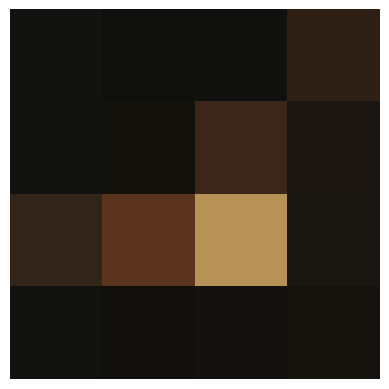

In [ ]:
def get_dataloader_tf(batch_size, image_size, data_dir):
    def preprocess_image(image, label):
        image = tf.image.resize(image, [image_size, image_size])
        image = tf.cast(image, tf.float32)
        image = (image - 127.5) / 127.5
        return image, label

    data = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        label_mode='int',
        image_size=(image_size, image_size),
        batch_size=batch_size
    )

    data = data.map(preprocess_image).prefetch(tf.data.experimental.AUTOTUNE)

    return data

def tensor_imshow(image):
    plt.imshow((image.numpy() * 127.5 + 127.5).astype("uint8"))
    plt.axis("off")
    plt.show()

# Testing the dataloader
image_root = 'resized'

batch_size, image_size = 5, 4
train_loader = get_dataloader_tf(batch_size, image_size, image_root)
dataiter = iter(train_loader)

img, _ = next(dataiter)
sample_img = img[-1]
tensor_imshow(sample_img)


In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
def print_tensor_images(images_tensor):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.subplots_adjust(wspace=0, hspace=0)
    
    npimgs = images_tensor.numpy()
    
    no_plots = len(npimgs)

    for idx, image in enumerate(npimgs):
        plt.subplot(1, 8, idx+1)
        plt.axis('off')
        # dnorm
        image = image * 0.5 + 0.5
        plt.imshow(image)  # Removed np.transpose
    plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

class ProGANGenerator(tf.keras.Model):
    def __init__(self, z_dim=100, in_chan=3, hidden_dim=64):
        super(ProGANGenerator, self).__init__()

        self.z_dim = z_dim
        self.in_chan = in_chan
        self.hidden_dim = hidden_dim

        self.initial_layer = tf.keras.Sequential([
            tf.keras.layers.Dense(4 * 4 * hidden_dim * 8, use_bias=False, input_shape=(z_dim,)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Reshape((4, 4, hidden_dim * 8)),
        ])

        self.progress_blocks = [
            self.make_gen_block(hidden_dim * 8, hidden_dim * 8),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, hidden_dim // 2),
            self.make_gen_block(hidden_dim // 2, hidden_dim // 4),
            self.make_gen_block(hidden_dim // 4, hidden_dim // 8),
        ]

        self.to_rgb = [
            tf.keras.Sequential([
                tf.keras.layers.Conv2D(in_chan, (1, 1), padding='same', use_bias=False, activation='tanh')
            ])
            for _ in range(len(self.progress_blocks))
        ]

    def make_gen_block(self, in_channels, out_channels):
        return tf.keras.Sequential([
            tf.keras.layers.UpSampling2D(),
            tf.keras.layers.Conv2D(out_channels, (3, 3), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(out_channels, (3, 3), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
        ])

    def call(self, noise, alpha, phase):
        x = self.initial_layer(noise)

        for i, block in enumerate(self.progress_blocks):

            x = block(x)
            if i == phase:
                break

        if phase > 0:
            x_prev = self.to_rgb[phase - 1](x)
            x = self.to_rgb[phase](x)
            x = alpha * x + (1 - alpha) * x_prev
        else:
            x = self.to_rgb[0](x)
        return x

class Discriminator(tf.keras.Model):
    def __init__(self, initial_filters=64):
        super(Discriminator, self).__init__()

        self.initial_filters = initial_filters
        self.from_rgb = [
            tf.keras.layers.Conv2D(initial_filters // 4, kernel_size=1, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(initial_filters // 2, kernel_size=1, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(initial_filters, kernel_size=1, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(initial_filters * 2, kernel_size=1, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(initial_filters * 4, kernel_size=1, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(initial_filters * 8, kernel_size=1, strides=1, padding='same'),
            tf.keras.layers.LeakyReLU()
        ]

        self.progress_blocks = [
            self.make_disc_block(initial_filters // 4, initial_filters // 2),
            self.make_disc_block(initial_filters // 2, initial_filters),
            self.make_disc_block(initial_filters, initial_filters * 2),
            self.make_disc_block(initial_filters * 2, initial_filters * 4),
            self.make_disc_block(initial_filters * 4, initial_filters * 8),
            self.make_disc_block(initial_filters * 8, initial_filters * 8),
            # Add more blocks as needed to increase resolution
        ]

        self.final_block = tf.keras.Sequential([
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1)
        ])

    def make_disc_block(self, in_channels, out_channels):
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(out_channels, (3, 3), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.Conv2D(out_channels, (3, 3), padding='same', use_bias=False),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(),
            tf.keras.layers.AveragePooling2D()
        ])

    def call(self, images, alpha, phase):
        if phase == 0:
            x = self.from_rgb[phase](images)
            print("Shape after from_rgb:phase0", x.get_shape())
            x = self.progress_blocks[phase](x)
            print("Shape after progress_blocks[phase]:", x.get_shape())

        else:

            x_prev = self.from_rgb[phase - 1](images)
            print("Shape after from_rgb:phase1prev", x_prev.get_shape())
            x_prev = tf.keras.layers.AveragePooling2D()(x_prev)
            x_prev = self.progress_blocks[phase](x_prev)
            print("Shape after progress_blocks[phase]prev:", x_prev.get_shape())
            x = self.from_rgb[phase](images)
            x = self.progress_blocks[phase](x)
            x = alpha * x + (1 - alpha) * x_prev

        for i in range(phase + 1, len(self.progress_blocks)):
            x = self.progress_blocks[i](x)

        x = self.final_block(x)
        return x



In [ ]:
def wasserstein_loss(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def real_loss(D_out):
    return wasserstein_loss(tf.ones_like(D_out), D_out)


def fake_loss(D_out):
    return wasserstein_loss(-tf.ones_like(D_out), D_out)

    
def gradient_penalty(real_images, fake_images, discriminator):
    epsilon = tf.random.uniform([real_images.shape[0], 1, 1, 1], 0, 1)
    interpolates = epsilon * real_images + (1 - epsilon) * fake_images
    with tf.GradientTape() as tape:
        tape.watch(interpolates)
        disc_interpolates = discriminator(interpolates)
    gradients = tape.gradient(disc_interpolates, [interpolates])[0]
    gradients_sqr = tf.square(gradients)
    gradients_sqr_sum = tf.reduce_sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    gradient_penalty = tf.reduce_mean((gradients_sqr_sum - 1) ** 2)
    return gradient_penalty
def train(D, G, n_epochs, dataloader, d_optimizer, g_optimizer, z_dim, alpha, phase, print_every=50, gp=10):
    ## Get some fixed data for sampling.##      
    sample_size = 8
    fixed_z = get_noise(n_samples=sample_size, z_dim=z_dim)

    for epoch in range(1, n_epochs+1):

        for batch_i, (real_images, _) in enumerate(dataloader):

            batch_size = real_images.shape[0]

            ### Discriminator part ###
            with tf.GradientTape() as tape:
                # Loss on real image
                d_real_op = D(real_images, alpha, phase)

                d_real_loss = real_loss(d_real_op)

                # Loss on fake image
                noise = get_noise(n_samples=batch_size, z_dim=z_dim)
                fake_images = G(noise, alpha, phase)
                d_fake_op = D(fake_images, alpha, phase)
                d_fake_loss = fake_loss(d_fake_op)

                # Total loss
                d_loss = d_real_loss + d_fake_loss

            gradients = tape.gradient(d_loss, D.trainable_variables)
            d_optimizer.apply_gradients(zip(gradients, D.trainable_variables))

            # Gradient penalty computation
            gradient_penalty = gradient_penalty(real_images, fake_images, D)
            d_loss += gp * gradient_penalty
            gradients = tape.gradient(d_loss, D.trainable_variables)
            d_optimizer.apply_gradients(zip(gradients, D.trainable_variables))

            ### Generator part ###
            with tf.GradientTape() as tape:
                noise = get_noise(n_samples=batch_size, z_dim=z_dim)
                g_out = G(noise, alpha, phase)
                d_out = D(g_out, alpha, phase)
                
                g_loss = real_loss(d_out)

            gradients = tape.gradient(g_loss, G.trainable_variables)
            g_optimizer.apply_gradients(zip(gradients, G.trainable_variables))
        
        print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                                epoch, n_epochs, d_loss.numpy(), g_loss.numpy()))
        if (epoch % print_every == 0):
            G.trainable = False
            sample_image = G(fixed_z, alpha, phase)
            print_tensor_images(sample_image)
            G.trainable = True


# Model initialization
image_size = 4
gen = ProGANGenerator(z_dim=100, in_chan=3, hidden_dim=64)
initial_filters = 64
z_dim = 100
disc = Discriminator(initial_filters = 64)



# Optimizer initialization
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0, beta_2=0.99)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0, beta_2=0.99)


train_dataset = get_dataloader_tf(batch_size, image_size, image_root)


Found 8683 files belonging to 1 classes.


In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4, 4, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
def get_noise(n_samples, z_dim, seed=None):
    if seed is not None:
        tf.random.set_seed(seed)
    return tf.random.normal([n_samples, z_dim])


In [ ]:
# Test the generator
z = tf.random.normal([5, 100])
gen = ProGANGenerator()
gen_output = gen(z, alpha=0.5, phase=1)
print("Generator output shape:", gen_output.shape)


Generator output shape: (5, 16, 16, 3)


In [ ]:
# Test the discriminator
disc = Discriminator()
disc_output = disc(gen_output, alpha=0.5, phase=0)
print("Discriminator output shape:", disc_output.shape)

Shape after from_rgb:phase0 (5, 16, 16, 16)
Shape after progress_blocks[phase]: (5, 8, 8, 32)
Discriminator output shape: (5, 1)


In [ ]:
# Training hyperparameters
n_epochs = 2
z_dim = 100
alpha = 0.5
phase = 0  # Set this according to the desired resolution

# Train the model
train(disc, gen, n_epochs, train_dataset, d_optimizer, g_optimizer, z_dim, alpha, phase, print_every=5, gp=10)


Shape after from_rgb:phase0 (5, 4, 4, 16)
Shape after progress_blocks[phase]: (5, 2, 2, 32)


ValueError: ignored

In [ ]:
dat

NameError: ignored

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, initializers

class WSConv2D(layers.Layer):
    """
    Weight scaled Conv2D (Equalized Learning Rate)
    Note that input is multiplied rather than changing weights
    this will have the same result.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding="same", gain=2, **kwargs):
        super(WSConv2D, self).__init__(**kwargs)
        self.conv = layers.Conv2D(out_channels, kernel_size, strides=stride, padding=padding, use_bias=False)
        self.scale = (gain / (in_channels * (kernel_size ** 2))) ** 0.5
        self.bias = self.add_weight(shape=(out_channels,), initializer=initializers.Zeros(), trainable=True)

        # Initialize conv layer
        initializers.RandomNormal(stddev=1.0)(self.conv.kernel)

    def call(self, x):
        x = self.conv(x * self.scale)
        x = x + self.bias[None, None, None, :]
        return x


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import Model
from math import log2

class PixelNorm(Layer):
    def __init__(self, epsilon=1e-8):
        super(PixelNorm, self).__init__()
        self.epsilon = epsilon

    def call(self, x):
        return x / tf.sqrt(tf.reduce_mean(x ** 2, axis=-1, keepdims=True) + self.epsilon)


class ConvBlock(Model):
    def __init__(self, in_channels, out_channels, use_pixelnorm=True):
        super(ConvBlock, self).__init__()
        self.use_pn = use_pixelnorm
        self.conv1 = WSConv2D(in_channels, out_channels)
        self.conv2 = WSConv2D(out_channels, out_channels)
        self.leaky = tf.keras.layers.LeakyReLU(0.2)
        self.pn = PixelNorm()

    def call(self, x):
        x = self.leaky(self.conv1(x))
        x = self.pn(x) if self.use_pn else x
        x = self.leaky(self.conv2(x))
        x = self.pn(x) if self.use_pn else x
        return x

# Generator class
class Generator(Model):
    def __init__(self, z_dim, in_channels, img_channels=3):
        super(Generator, self).__init__()

        self.initial = tf.keras.Sequential([
            PixelNorm(),
            tf.keras.layers.Conv2DTranspose(z_dim, in_channels, 4, 1, "valid"),
            tf.keras.layers.LeakyReLU(0.2),
            WSConv2D(in_channels, in_channels, kernel_size=3, stride=1, padding="same"),
            tf.keras.layers.LeakyReLU(0.2),
            PixelNorm(),
        ])

        self.initial_rgb = WSConv2D(in_channels, img_channels, kernel_size=1, stride=1, padding="valid")
        self.prog_blocks, self.rgb_layers = (
            [ConvBlock(int(in_channels * factors[i]), int(in_channels * factors[i + 1])) for i in range(len(factors) - 1)],
            [self.initial_rgb] + [WSConv2D(int(in_channels * factors[i + 1]), img_channels, kernel_size=1, stride=1, padding="valid") for i in range(len(factors) - 1)],
        )

    def fade_in(self, alpha, upscaled, generated):
        return tf.tanh(alpha * generated + (1 - alpha) * upscaled)

    def call(self, x, alpha, steps):
        out = self.initial(x)

        if steps == 0:
            return self.initial_rgb(out)

        for step in range(steps):
            upscaled = tf.image.resize(out, size=tf.shape(out)[1:3] * 2, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            out = self.prog_blocks[step](upscaled)

        final_upscaled = self.rgb_layers[steps - 1](upscaled)
        final_out = self.rgb_layers[steps](out)
        return self.fade_in(alpha, final_upscaled, final_out)

class Discriminator(Model):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = (
            [ConvBlock(int(in_channels * factors[i]), int(in_channels * factors[i - 1]), use_pixelnorm=False) for i in range(len(factors) - 1, 0, -1)],
            [WSConv2D(img_channels, int(in_channels * factors[i]), kernel_size=1, stride=1, padding="valid") for i in range(len(factors) - 1, -1, -1)],
        )

        self.leaky = tf.keras.layers.LeakyReLU(0.2)
        self.avg_pool = tf.keras.layers.AveragePooling2D(pool_size=2, strides=2)

        self.final_block = tf.keras.Sequential([
            WSConv2D(in_channels + 1, in_channels, kernel_size=3, padding="same"),
            tf.keras.layers.LeakyReLU(0.2),
            WSConv2D(in_channels, in_channels, kernel_size=4, padding="valid", stride=1),
            tf.keras.layers.LeakyReLU(0.2),
            WSConv2D(in_channels, 1, kernel_size=1, padding="valid", stride=1),
        ])

    def fade_in(self, alpha, downscaled, out):
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = tf.math.reduce_std(x, axis=0)
        batch_statistics = tf.math.reduce_mean(batch_statistics)
        batch_statistics = tf.tile(batch_statistics[tf.newaxis, tf.newaxis, tf.newaxis], [tf.shape(x)[0], 1, tf.shape(x)[2], tf.shape(x)[3]])
        return tf.concat([x, batch_statistics], axis=1)

    def call(self, x, alpha, steps):
        cur_step = len(self.prog_blocks) - steps
        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:
            out = self.minibatch_std(out)
            return self.final_block(out)

        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))
        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out)

# Testing code
if __name__ == "__main__":
    Z_DIM = 100
    IN_CHANNELS = 256
    gen = Generator(Z_DIM, IN_CHANNELS, img_channels=3)
    critic = Discriminator(IN_CHANNELS, img_channels=3)

    for img_size in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
        num_steps = int(log2(img_size / 4))
        x = tf.random.normal((1, 1, 1, Z_DIM))
        z = gen(x, 0.5, steps=num_steps)
        assert z.shape == (1, img_size, img_size, 3)
        out = critic(z, alpha=0.5, steps=num_steps)
        assert out.shape == (1, 1, 1, 1)
       

